# Electric Vehicle Growth Prediction — Visual Analysis & Insights

This notebook focuses on **business-facing visuals** using matplotlib only:
- Distribution of predicted growth likelihood
- Top tracts by growth likelihood
- Feature impact views (growth likelihood vs. key features)
- Calibration curve (predicted vs. observed)
- Optional geo scatter if longitude/latitude are available

It expects either:
- `data/cleaned_ev_area_data_scored.csv` (from 02), **or**
- `data/cleaned_ev_area_data.csv` + `models/random_forest_growth_model.joblib`

## Step 0 — Imports

In [25]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss

if Path.cwd().name == "notebooks":
    os.chdir(Path.cwd().parent)
print("Working directory set to:", Path.cwd())
print("data folder:", os.listdir("data"))
print("models folder:", os.listdir("models"))

plt.rcParams['figure.figsize'] = (6,4)
print("Matplotlib version:", plt.matplotlib.__version__)

plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.bbox"] = "tight"

def save_fig(filename):
    os.makedirs("figures", exist_ok=True)
    plt.savefig(os.path.join("figures", filename))

Working directory set to: C:\Users\Agree\Desktop\electric-vehicle-growth-prediction
data folder: ['.ipynb_checkpoints', 'cleaned_ev_area_data.csv', 'cleaned_ev_area_data_scored.csv', 'top_growth_tracts.csv']
models folder: ['random_forest_growth_model.joblib']
Matplotlib version: 3.10.0


## Step 1 — Load data (scored if available, otherwise score using model)

In [26]:
scored_path_candidates = [
    "data/cleaned_ev_area_data_scored.csv",
    "./cleaned_ev_area_data_scored.csv"
]
raw_path_candidates = [
    "data/cleaned_ev_area_data.csv",
    "./cleaned_ev_area_data.csv"
]
model_path_candidates = [
    "models/random_forest_growth_model.joblib",
    "./models/random_forest_growth_model.joblib"
]

def first_existing(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    return None

scored_path = first_existing(scored_path_candidates)
raw_path = first_existing(raw_path_candidates)
model_path = first_existing(model_path_candidates)

if scored_path is not None:
    df = pd.read_csv(scored_path)
    print("Loaded scored dataset:", scored_path, "| shape:", df.shape)
elif raw_path is not None and model_path is not None:
    # Score on the fly
    import joblib
    from sklearn.ensemble import RandomForestClassifier
    print("Scored data not found. Loading raw cleaned data and model to score...")
    df = pd.read_csv(raw_path)
    rf = joblib.load(model_path)
    features = ["electric_range", "base_msrp", "model_year", "percent_bev"]
    missing = [c for c in features if c not in df.columns]
    if missing:
        raise KeyError(f"Missing features in cleaned dataset: {missing}")
    df["growth_likelihood"] = rf.predict_proba(df[features])[:, 1]
    print("Scored in-session. Shape:", df.shape)
else:
    raise FileNotFoundError("Could not find scored data or (raw+model). Make sure to run 02 first.")

# Basic sanity
expected_cols = {"2020_census_tract","vehicle_count","growth_likelihood","high_adoption",
                 "electric_range","base_msrp","model_year","percent_bev"}
present = expected_cols.intersection(df.columns)
print("Found expected columns:", sorted(present))
df.head()

Loaded scored dataset: data/cleaned_ev_area_data_scored.csv | shape: (2328, 8)
Found expected columns: ['2020_census_tract', 'base_msrp', 'electric_range', 'growth_likelihood', 'high_adoption', 'model_year', 'percent_bev', 'vehicle_count']


,2020_census_tract,vehicle_count,electric_range,base_msrp,model_year,percent_bev,high_adoption,growth_likelihood
0,1.001020e+09,2,19.5,0.0,2022.0,0.5,0,0.00625
1,1.001021e+09,1,25.0,0.0,2022.0,0.0,0,0.00000
2,1.045020e+09,1,0.0,0.0,2023.0,1.0,0,0.00000
3,1.081042e+09,1,220.0,0.0,2019.0,1.0,0,0.00000
4,1.117031e+09,1,259.0,0.0,2020.0,1.0,0,0.00000


## Step 2 — Distribution of growth likelihood

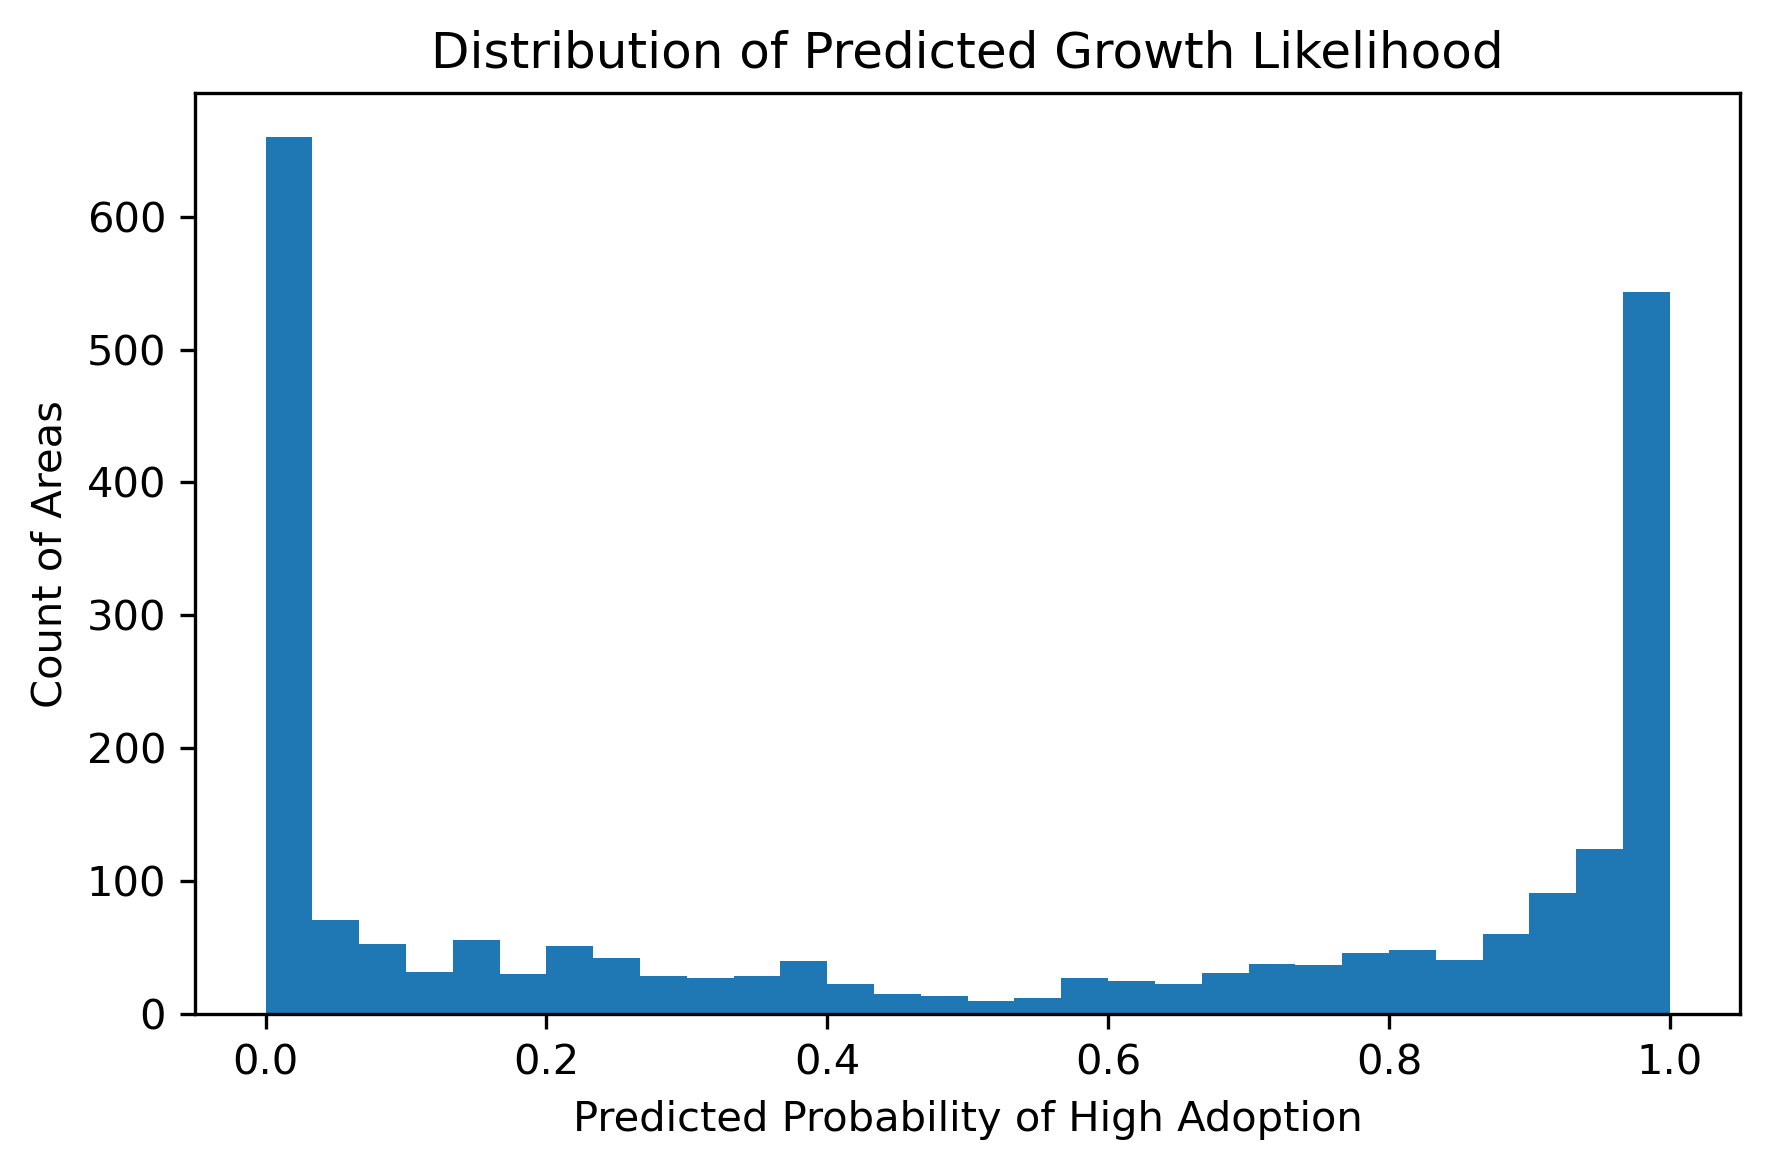

<Figure size 1800x1200 with 0 Axes>

In [27]:
if "growth_likelihood" not in df.columns:
    raise KeyError("growth_likelihood missing. Ensure 02 scored the dataset or scoring above succeeded.")

plt.figure()
plt.hist(df["growth_likelihood"], bins=30)
plt.title("Distribution of Predicted Growth Likelihood")
plt.xlabel("Predicted Probability of High Adoption")
plt.ylabel("Count of Areas")
plt.tight_layout()
plt.show()
save_fig("growth_likelihood.png")

## Step 3 — Top 25 tracts by growth likelihood

In [28]:
topN = (df.sort_values("growth_likelihood", ascending=False)
          .head(25)
          [["2020_census_tract","growth_likelihood","vehicle_count",
            "percent_bev","model_year","electric_range","base_msrp"]])
topN

,2020_census_tract,growth_likelihood,vehicle_count,percent_bev,model_year,electric_range,base_msrp
1394,5.303303e+10,1.0,503,0.906561,2022.131213,41.622266,589.662028
1609,5.305307e+10,1.0,224,0.816964,2022.611607,31.665179,743.973214
1608,5.305307e+10,1.0,659,0.845220,2022.663126,29.230653,414.946889
1134,5.303302e+10,1.0,484,0.882231,2022.123967,39.291322,464.152893
1133,5.303302e+10,1.0,423,0.886525,2022.524823,33.973995,107.801418
1132,5.303302e+10,1.0,587,0.851789,2022.313458,41.391823,299.395230
1121,5.303302e+10,1.0,504,0.863095,2022.083333,43.882937,271.517857
1116,5.303302e+10,1.0,310,0.812903,2022.006452,37.700000,412.258065
1115,5.303302e+10,1.0,370,0.840541,2022.221622,31.602703,418.243243
1114,5.303302e+10,1.0,298,0.842282,2021.932886,39.583893,682.046980


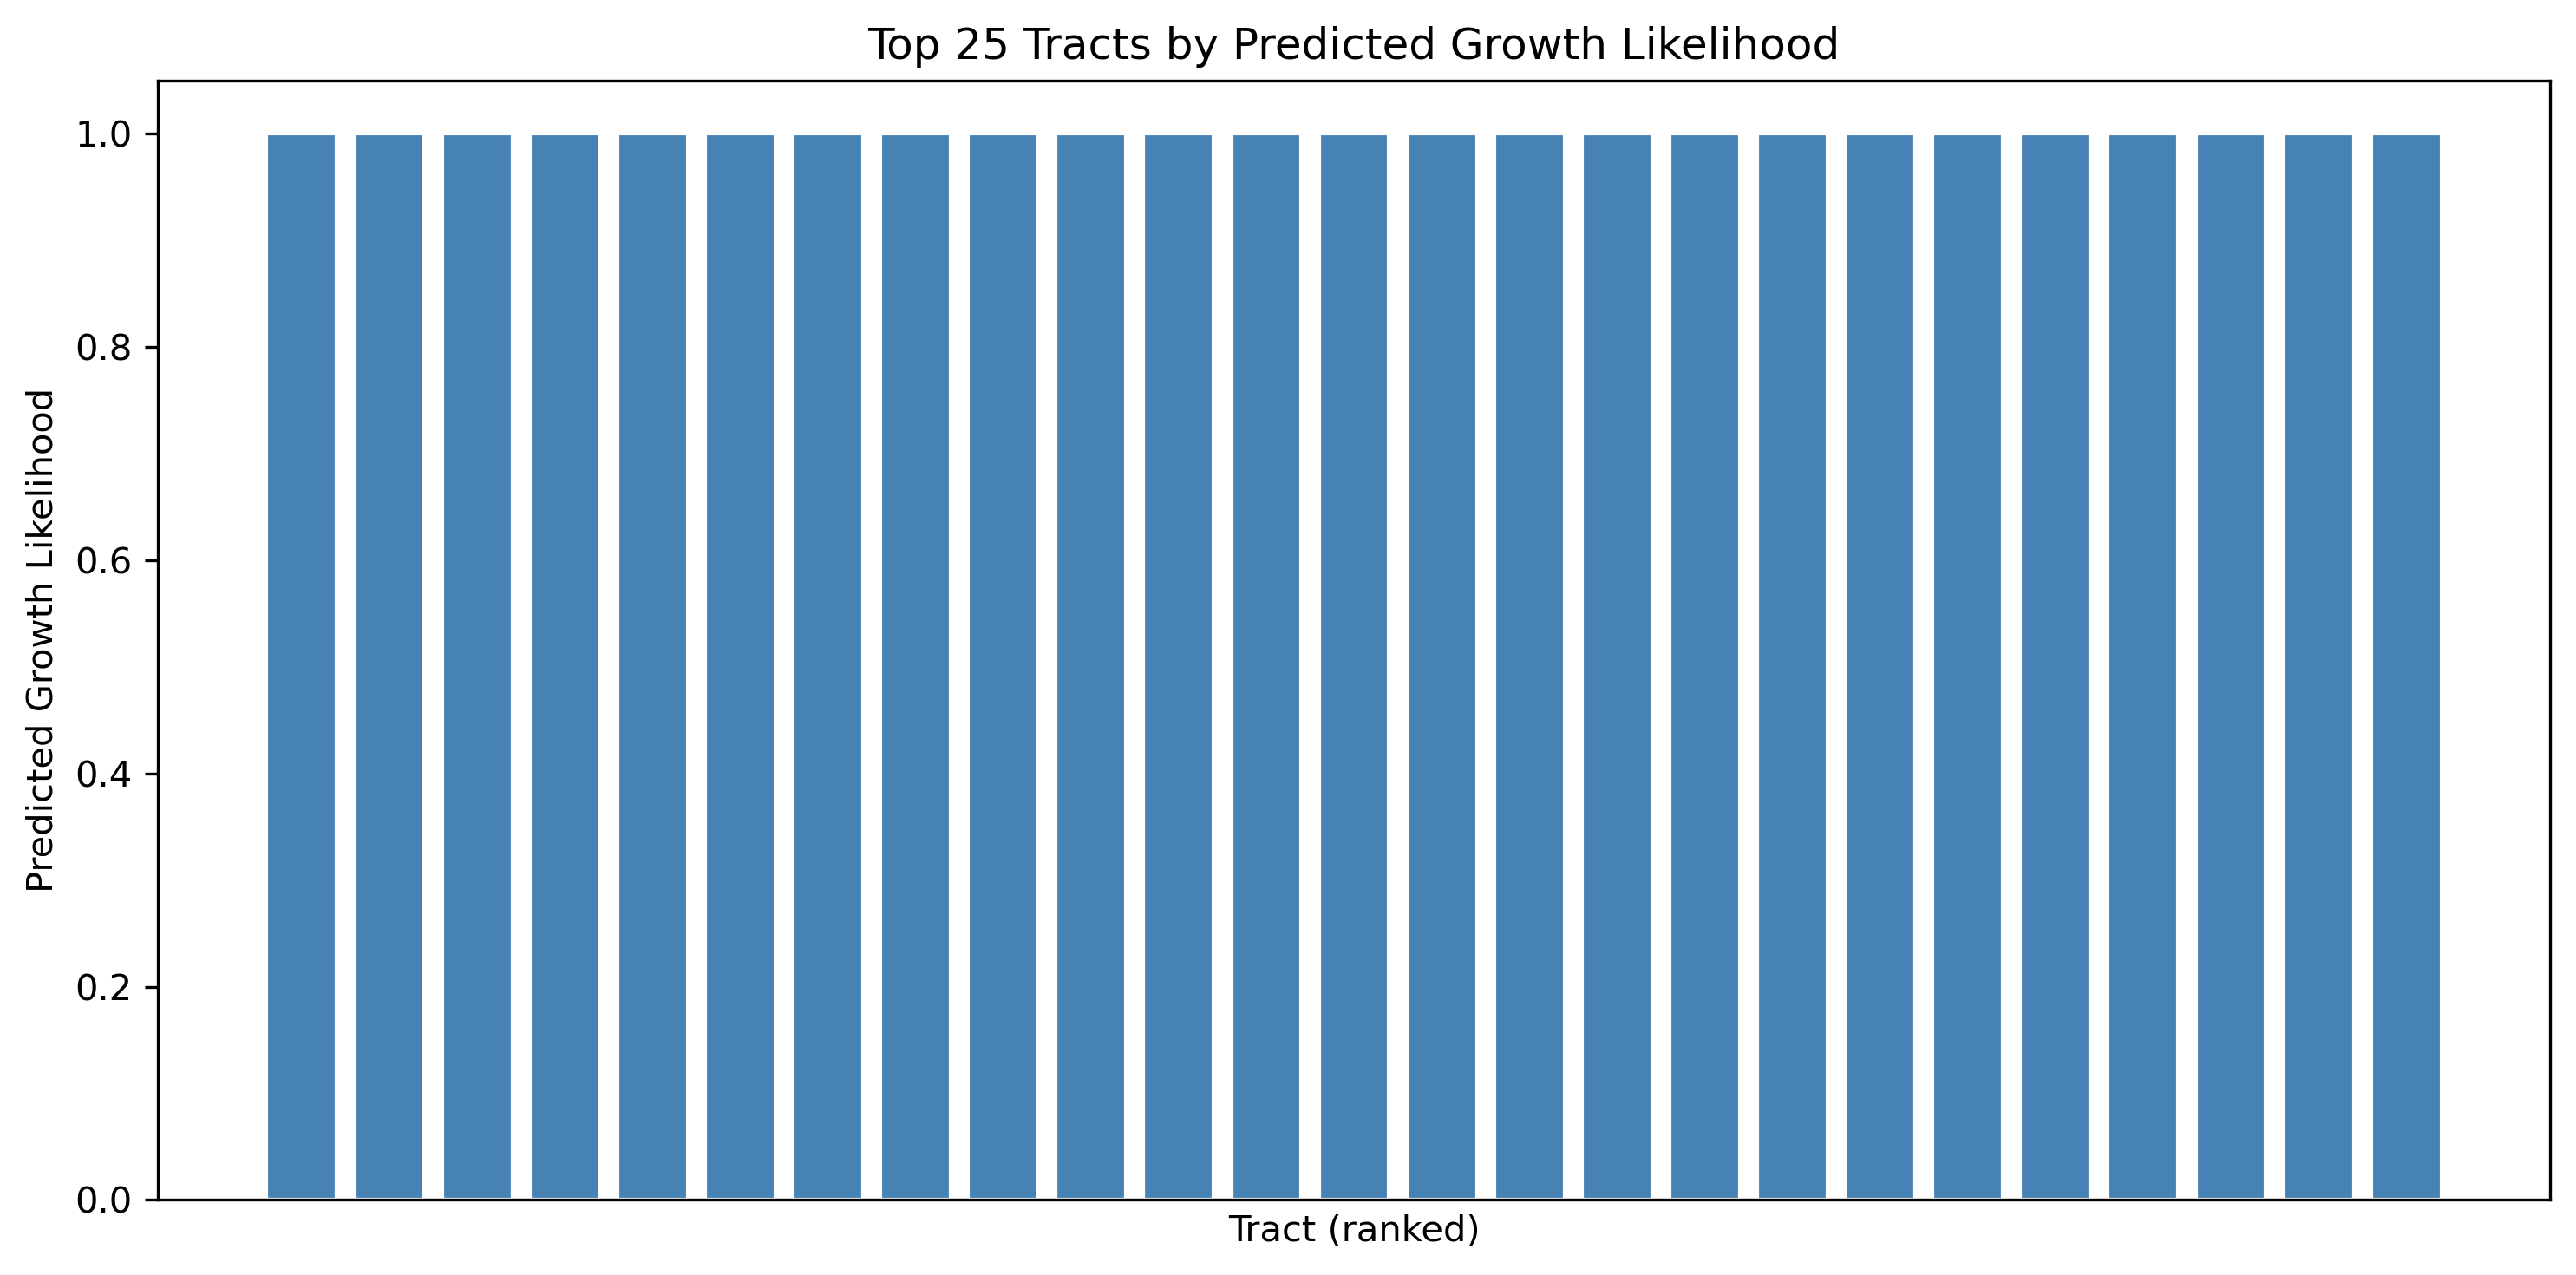

<Figure size 1800x1200 with 0 Axes>

In [29]:
# Bar chart
labels = topN["2020_census_tract"].astype(str).tolist()
vals = topN["growth_likelihood"].values

plt.figure(figsize=(10,5))
plt.bar(range(len(vals)), vals, color="steelblue", edgecolor="white")
plt.title("Top 25 Tracts by Predicted Growth Likelihood")
plt.xlabel("Tract (ranked)")
plt.ylabel("Predicted Growth Likelihood")
plt.xticks([])  
plt.tight_layout()
plt.show()
save_fig("top_growth_tracts.png")

## Step 4 — Feature impact: growth likelihood vs key features

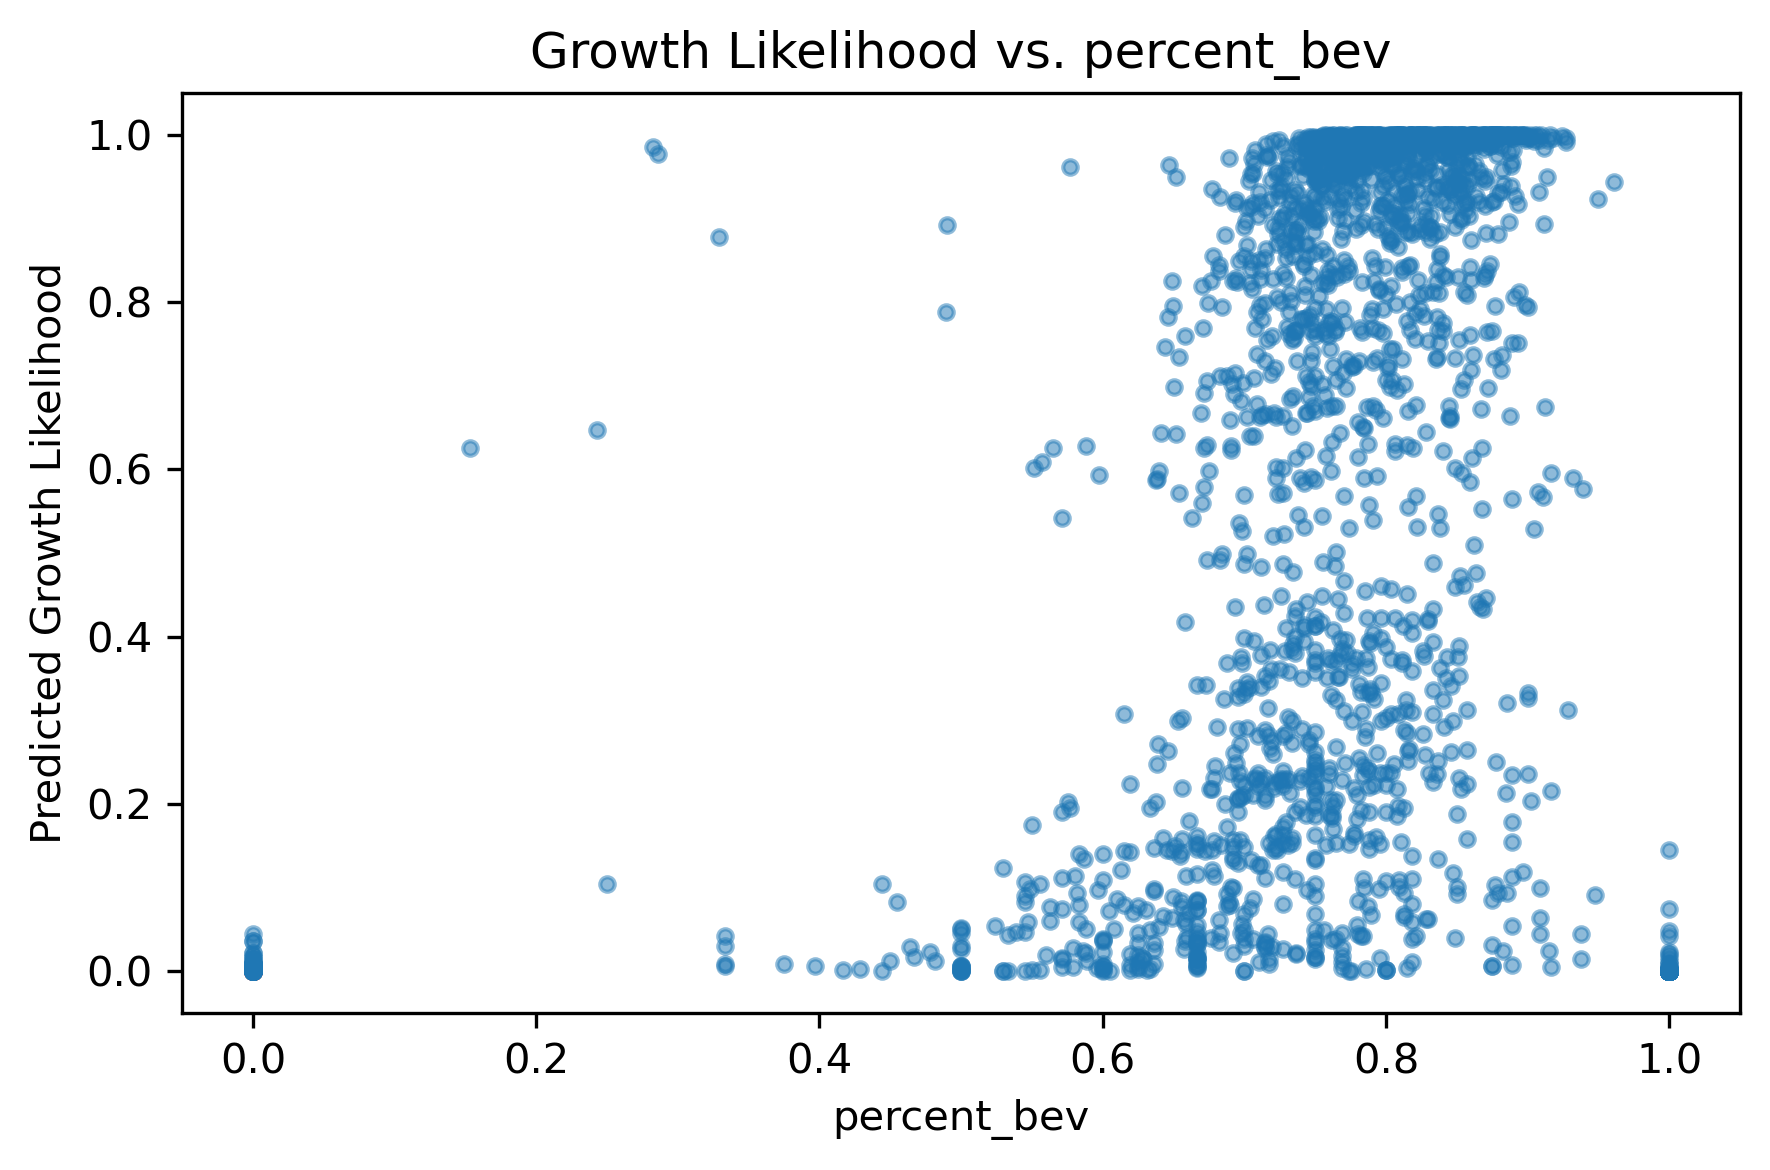

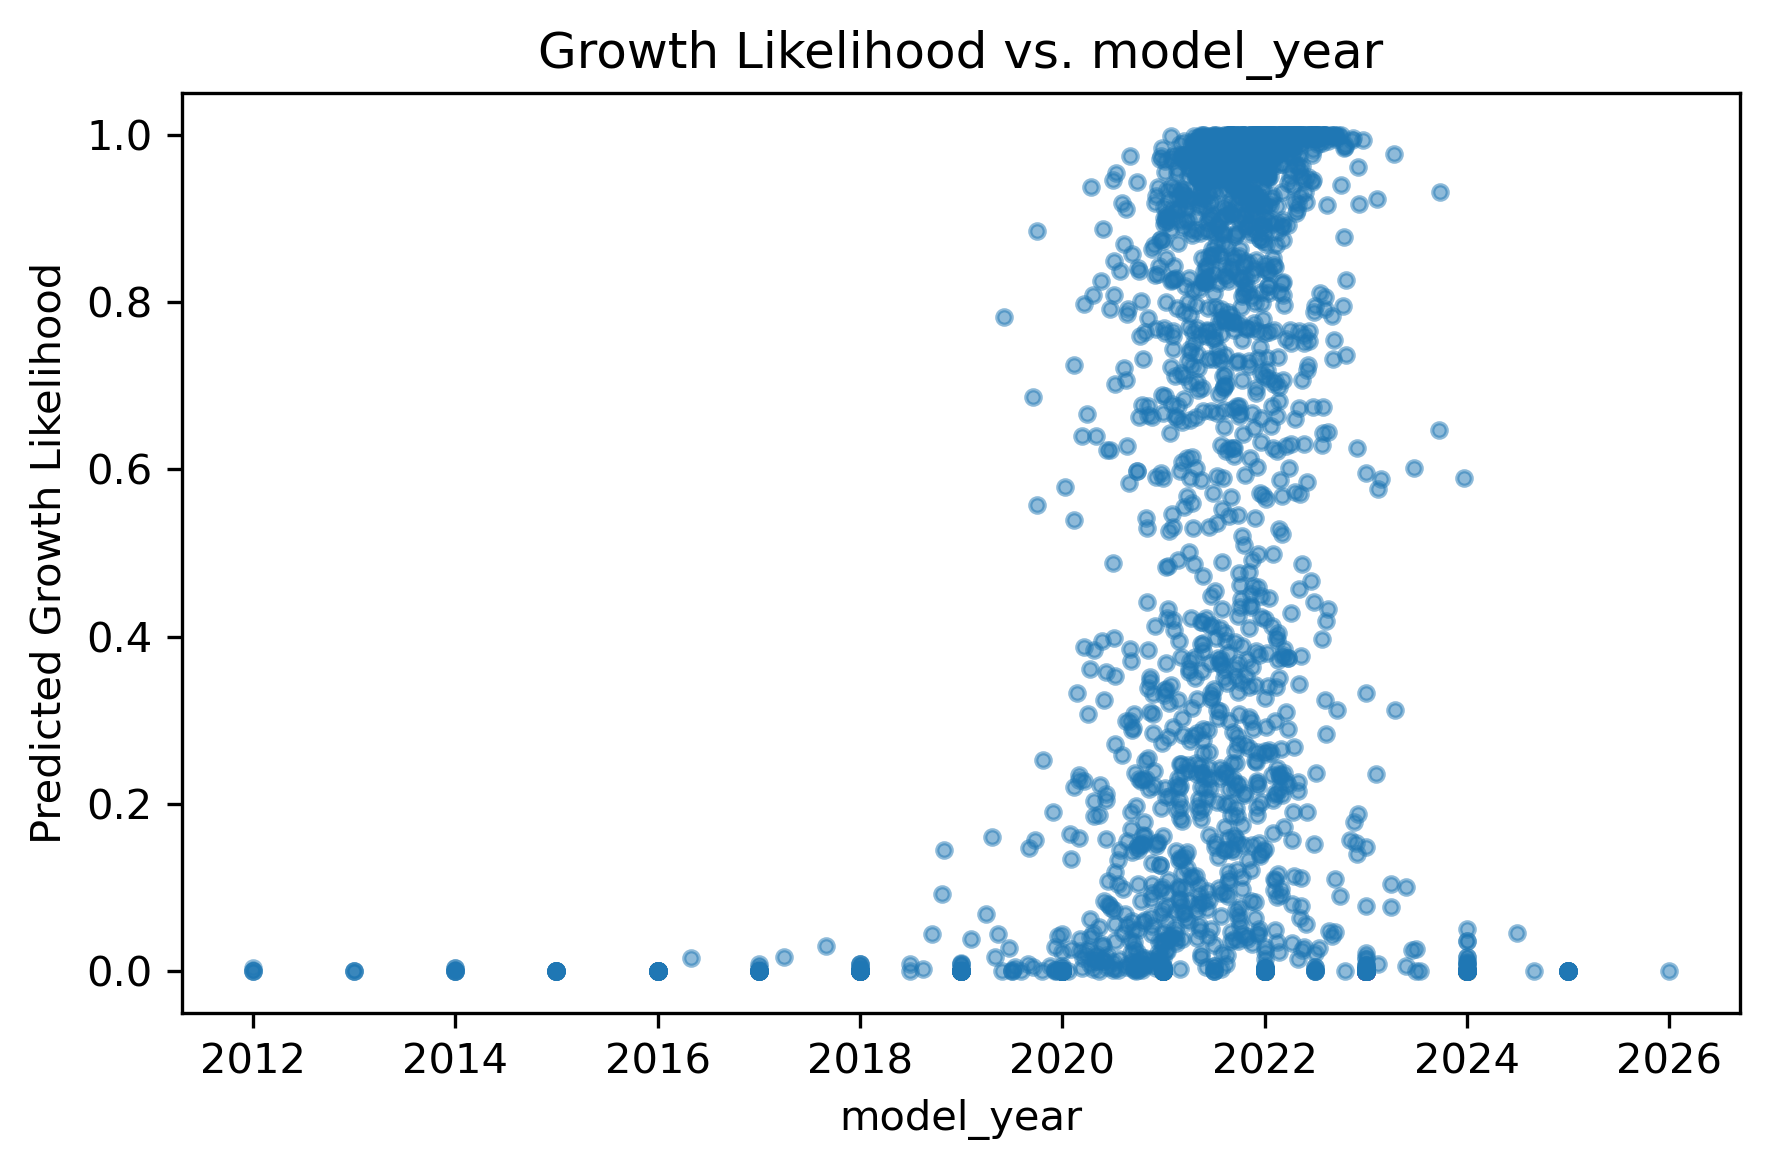

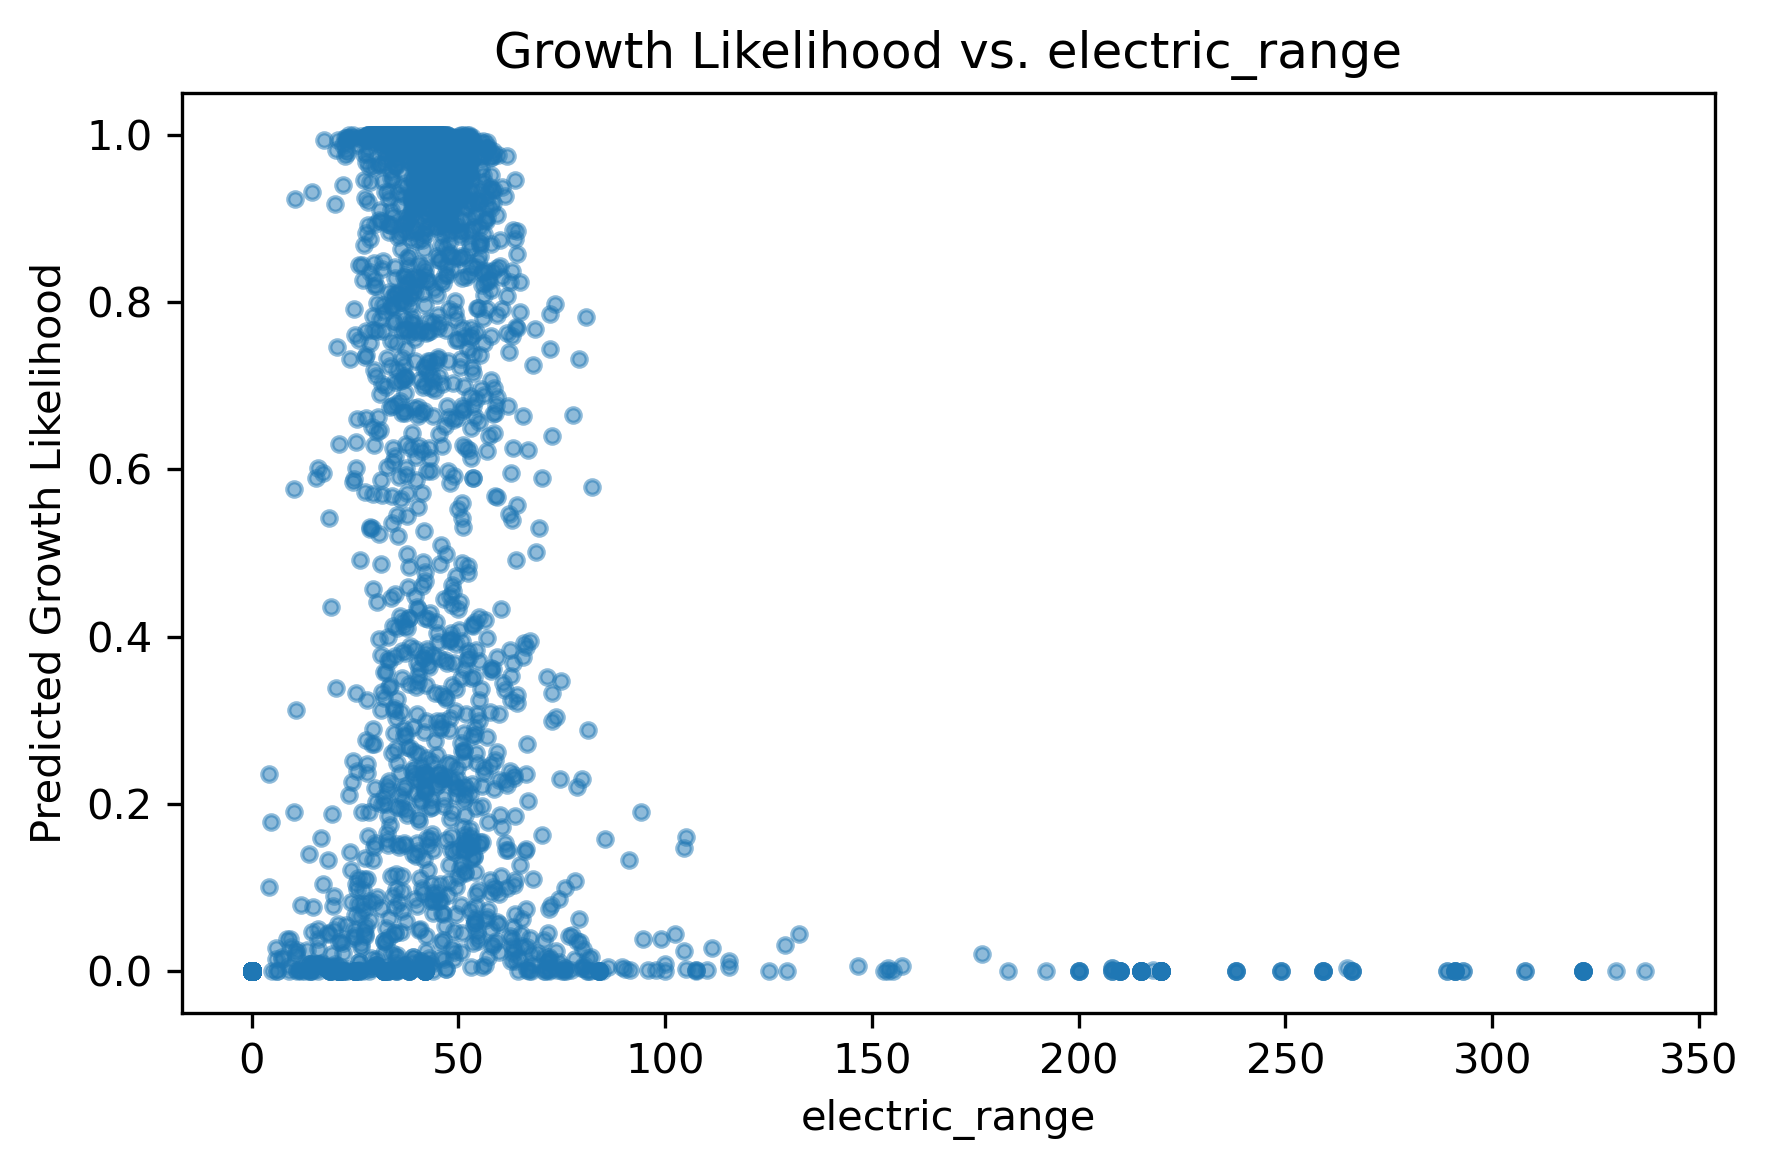

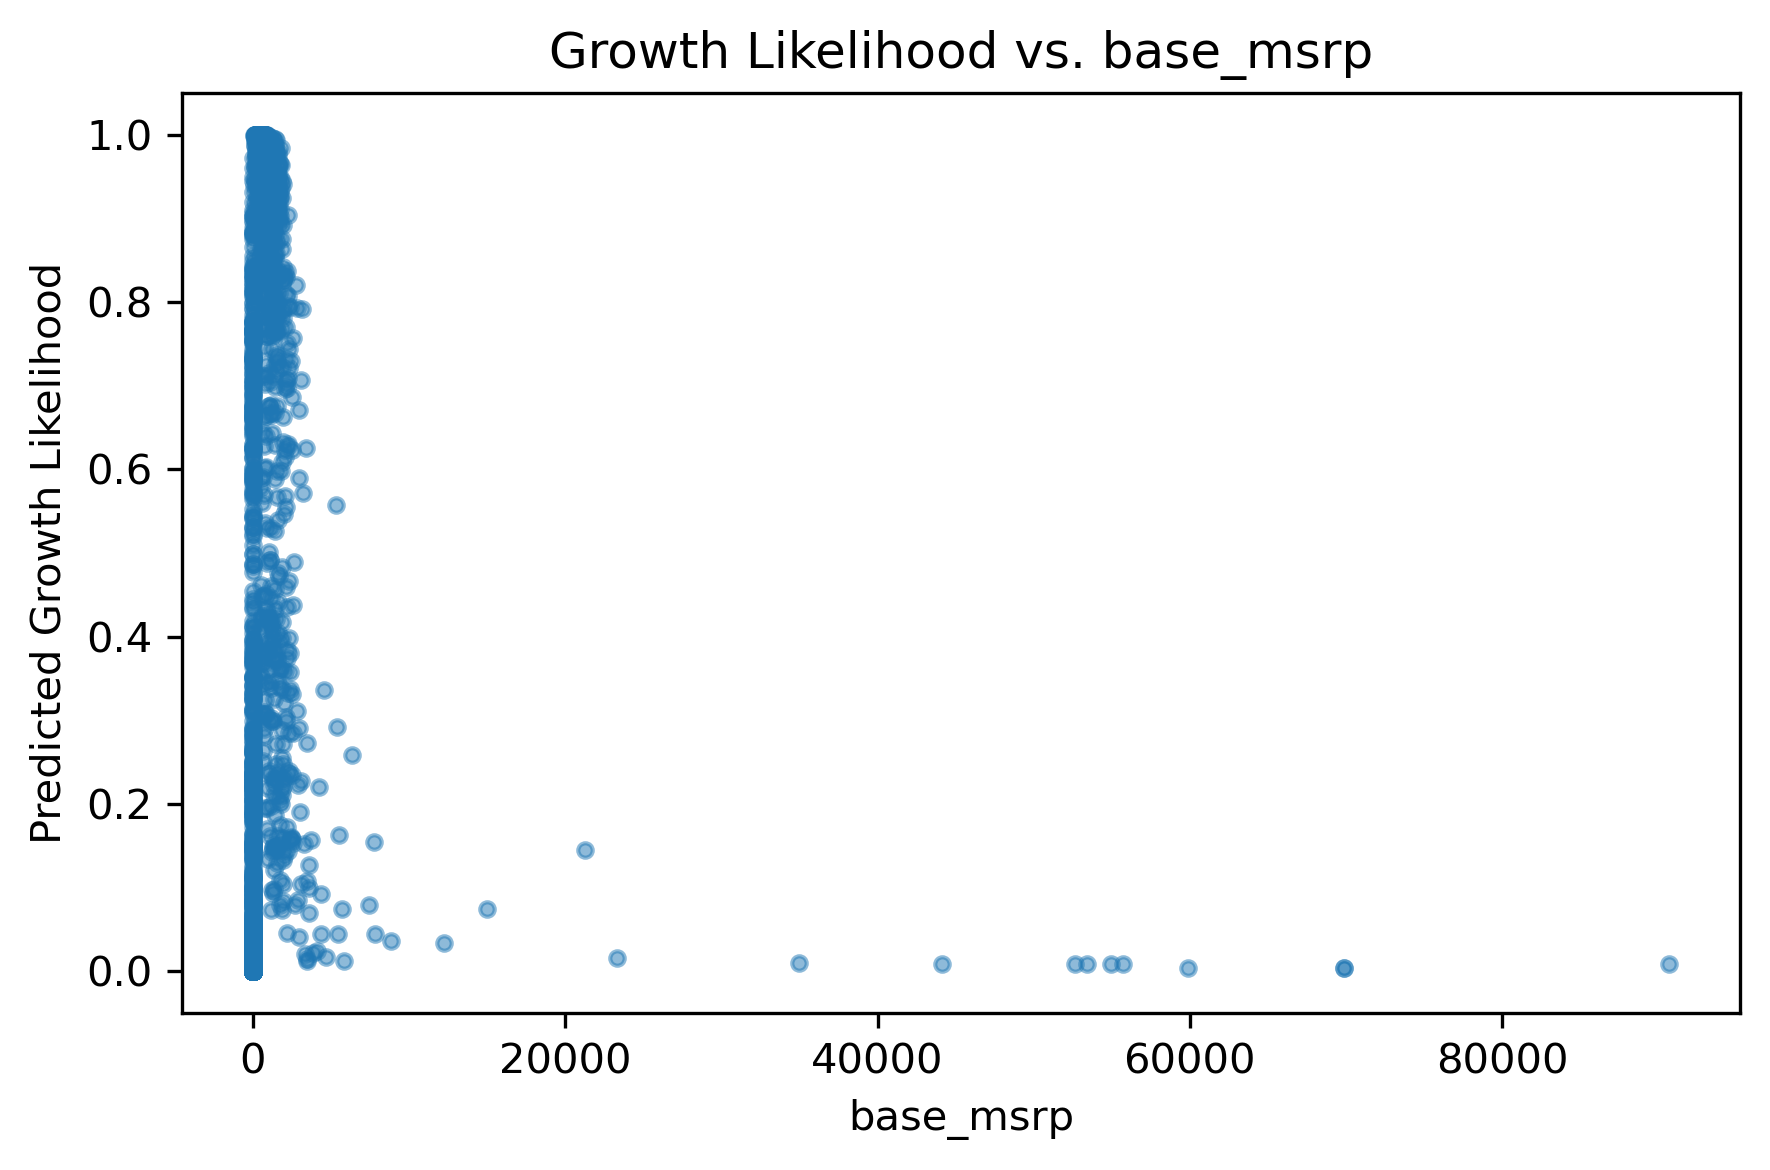

In [30]:
def scatter_feature(df, feat):
    if feat not in df.columns:
        print(f"Skipping: missing feature {feat}")
        return
    plt.figure()
    plt.scatter(df[feat], df["growth_likelihood"], s=12, alpha=0.5)
    plt.title(f"Growth Likelihood vs. {feat}")
    plt.xlabel(feat)
    plt.ylabel("Predicted Growth Likelihood")
    plt.tight_layout()
    plt.show()

for f in ["percent_bev", "model_year", "electric_range", "base_msrp"]:
    scatter_feature(df, f)

## Step 5 — Calibration curve (predicted vs. observed)

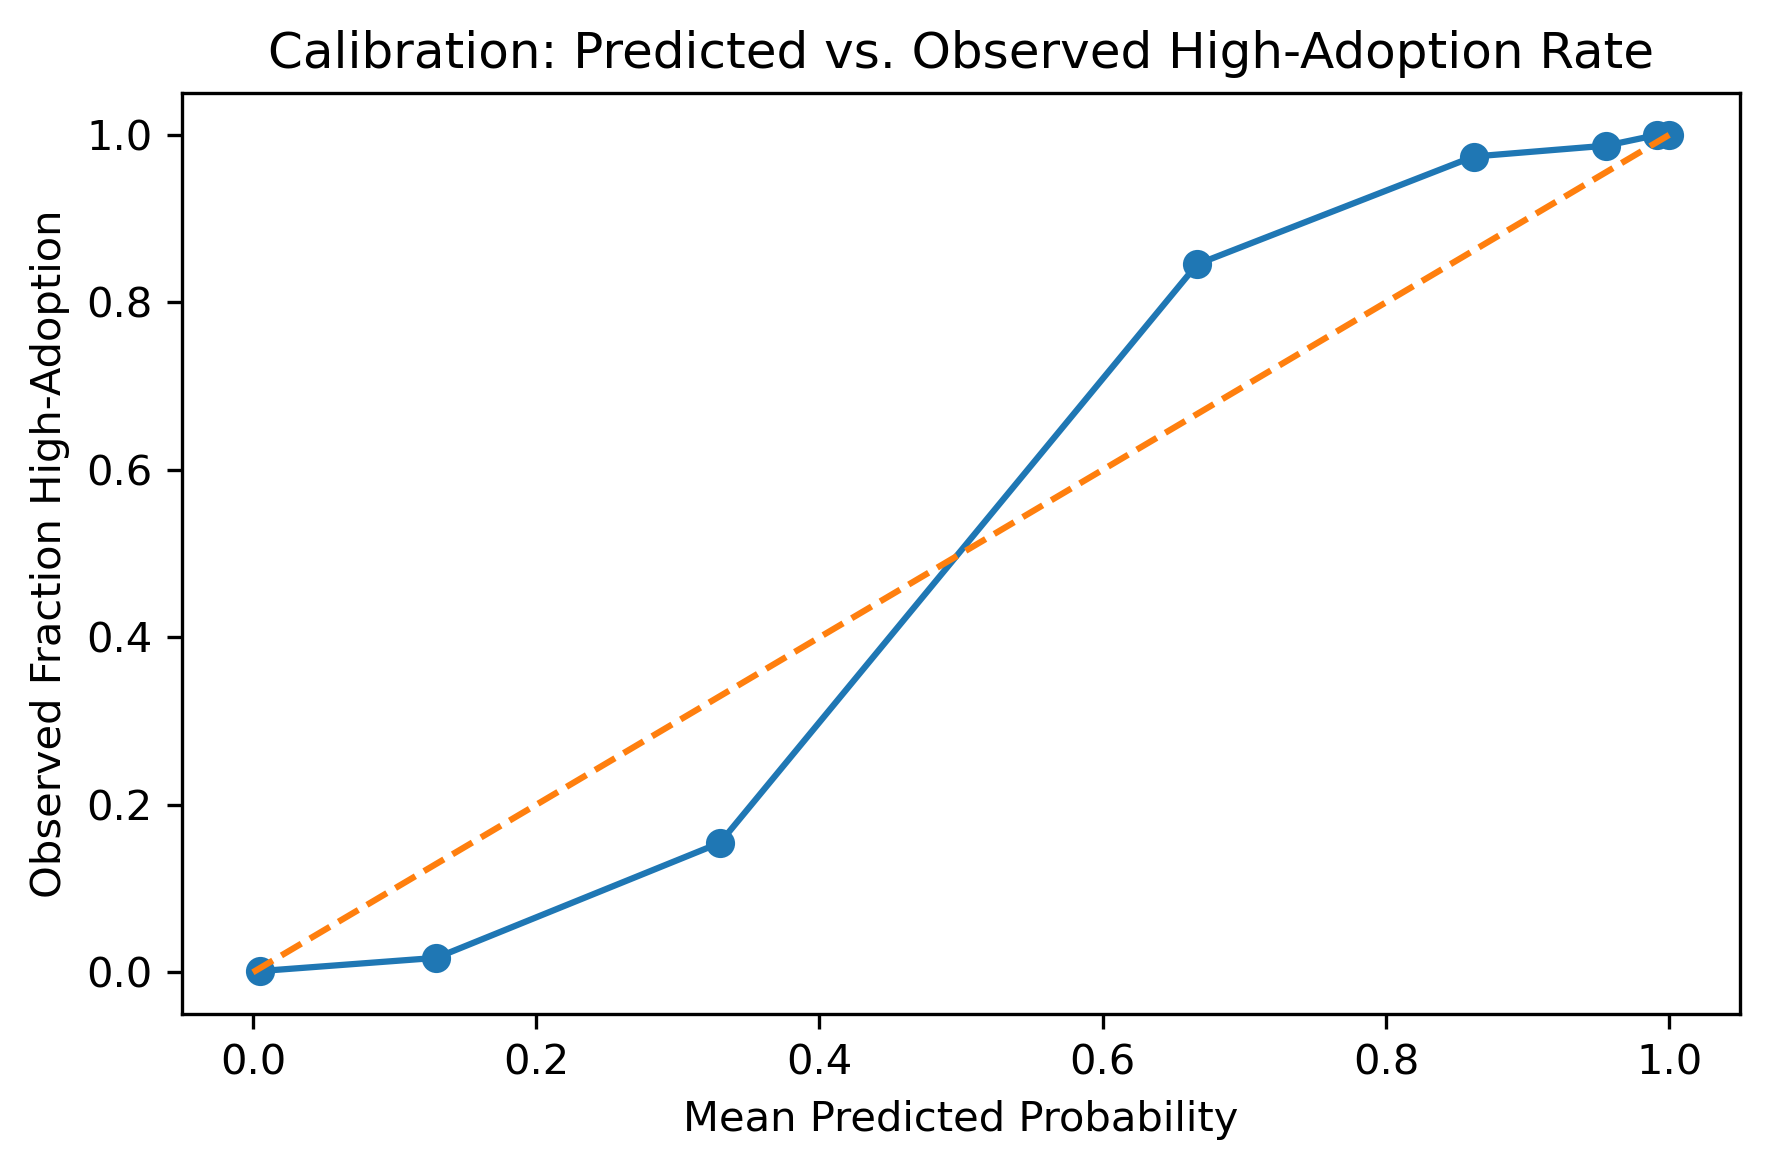

Brier score: 0.0388


In [31]:
# Bin by deciles of predicted probability and compare mean predicted vs actual rate
if "high_adoption" in df.columns:
    tmp = df[["growth_likelihood","high_adoption"]].dropna().copy()
    tmp["bin"] = pd.qcut(tmp["growth_likelihood"], q=10, labels=False, duplicates="drop")
    cal = tmp.groupby("bin").agg(pred=("growth_likelihood","mean"),
                                 obs=("high_adoption","mean"),
                                 n=("high_adoption","size")).reset_index()
    plt.figure()
    plt.plot(cal["pred"], cal["obs"], marker="o")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.title("Calibration: Predicted vs. Observed High-Adoption Rate")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Observed Fraction High-Adoption")
    plt.tight_layout()
    plt.show()

    # Brier score (lower is better)
    brier = brier_score_loss(tmp["high_adoption"], tmp["growth_likelihood"])
    print("Brier score:", round(brier, 4))
else:
    print("Skipping calibration: 'high_adoption' not present.")

## Step 6 — Save figures

In [32]:
os.makedirs("figures", exist_ok=True)

# Example: save the histogram again
plt.figure()
plt.hist(df["growth_likelihood"], bins=30)
plt.title("Distribution of Predicted Growth Likelihood")
plt.xlabel("Predicted Probability of High Adoption")
plt.ylabel("Count of Areas")
plt.tight_layout()
plt.savefig("figures/growth_likelihood_hist.png", dpi=200)
plt.close()

print("Saved: figures/growth_likelihood_hist.png")

Saved: figures/growth_likelihood_hist.png
